In [1]:
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

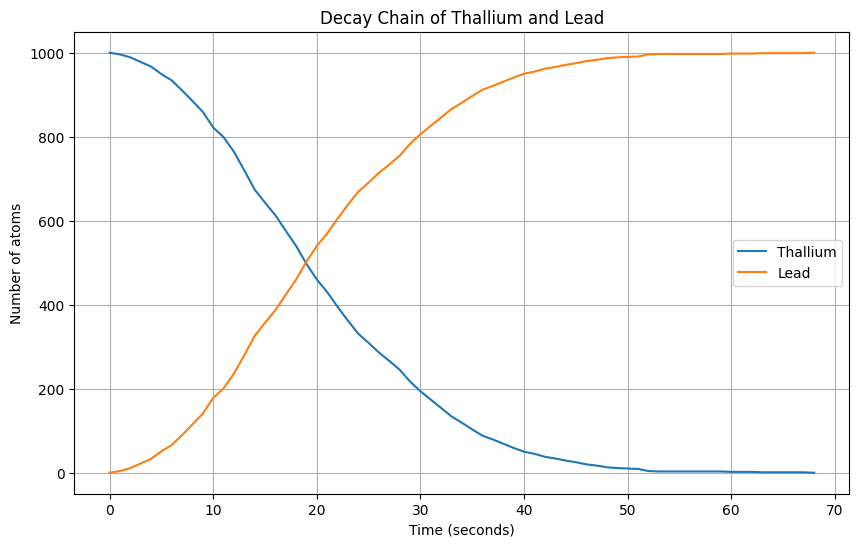

In [2]:
# Initial values of Thallium and Lead
tl, pb = 1000, 0
# Period in seconds 
tau = 3.052 * 60
# Probability at time t
p = lambda t: 1 - 2 ** (-t / tau)
# List to store the number of Tl and Pb atoms at each time step
evolution_history = [[tl, pb]]
# Simulation for the decay process
for t in range(1, 1000):
    # Random numbers
    random_numbers = np.random.random(tl)
    # Number of atoms that decay
    decay_count = sum(random_numbers < p(t))
    tl -= decay_count
    pb += decay_count
    evolution_history.append([tl, pb])
    if tl == 0:
        break
# Extracting data for plotting
time_steps = range(len(evolution_history))
tl_atoms = [step[0] for step in evolution_history]
pb_atoms = [step[1] for step in evolution_history]
# Plotting the evolution of Thallium and Lead atoms as a function of time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, tl_atoms, label='Thallium')
plt.plot(time_steps, pb_atoms, label='Lead')
plt.title('Decay Chain of Thallium and Lead')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of atoms')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\yesmi\AppData\Local\Temp\ipykernel_17812\1294780219.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  decay_count = np.sum(1 if (x >= i - 1 and x < i) else 0 for x in decay_times)


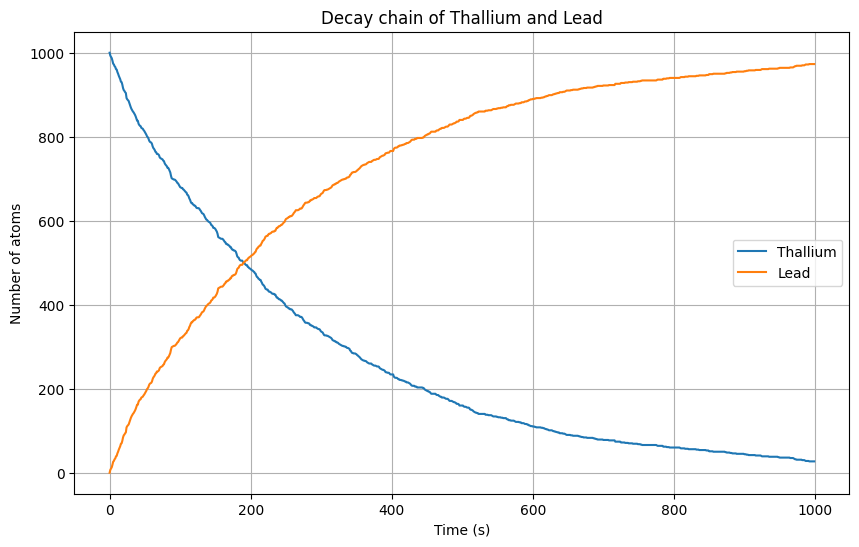

In [3]:
# Initial values of Thallium and Lead
tl, pb = 1000, 0
# Period in seconds 
tau  = 3.052 * 60
# Non-uniform probability distribution
p = lambda t: (2 ** (-t / tau)) * np.log(2) / tau
# Inverse cumulative distribution function of F(x)
inverse_cdf = lambda x: -tau * np.log2(1 - x)
# Generate random times of decay using the inverse transform method
decay_times = inverse_cdf(np.random.random(size=(tl,)))
decay_times.sort()
# List to store the number of Tl and Pb atoms at each time step
evolution_history = [[tl, pb]]
for i in range(1, len(decay_times)):
    decay_count = np.sum(1 if (x >= i - 1 and x < i) else 0 for x in decay_times)
    if decay_count >= tl or tl == 0:
        evolution_history.append([0, 1000])
        break
    else:
        tl -= decay_count
        pb += decay_count
        evolution_history.append([tl, pb])
# Extracting data for plotting
time_steps = range(len(evolution_history))
tl_atoms = [step[0] for step in evolution_history]
pb_atoms = [step[1] for step in evolution_history]
# Plotting the evolution of Thallium and Lead atoms as a function of time
plt.figure(figsize=(10, 6))
plt.plot(time_steps, tl_atoms, label='Thallium')
plt.plot(time_steps, pb_atoms, label='Lead')
plt.title('Decay chain of Thallium and Lead')
plt.xlabel('Time (s)')
plt.ylabel('Number of atoms')
plt.legend()
plt.grid(True)
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

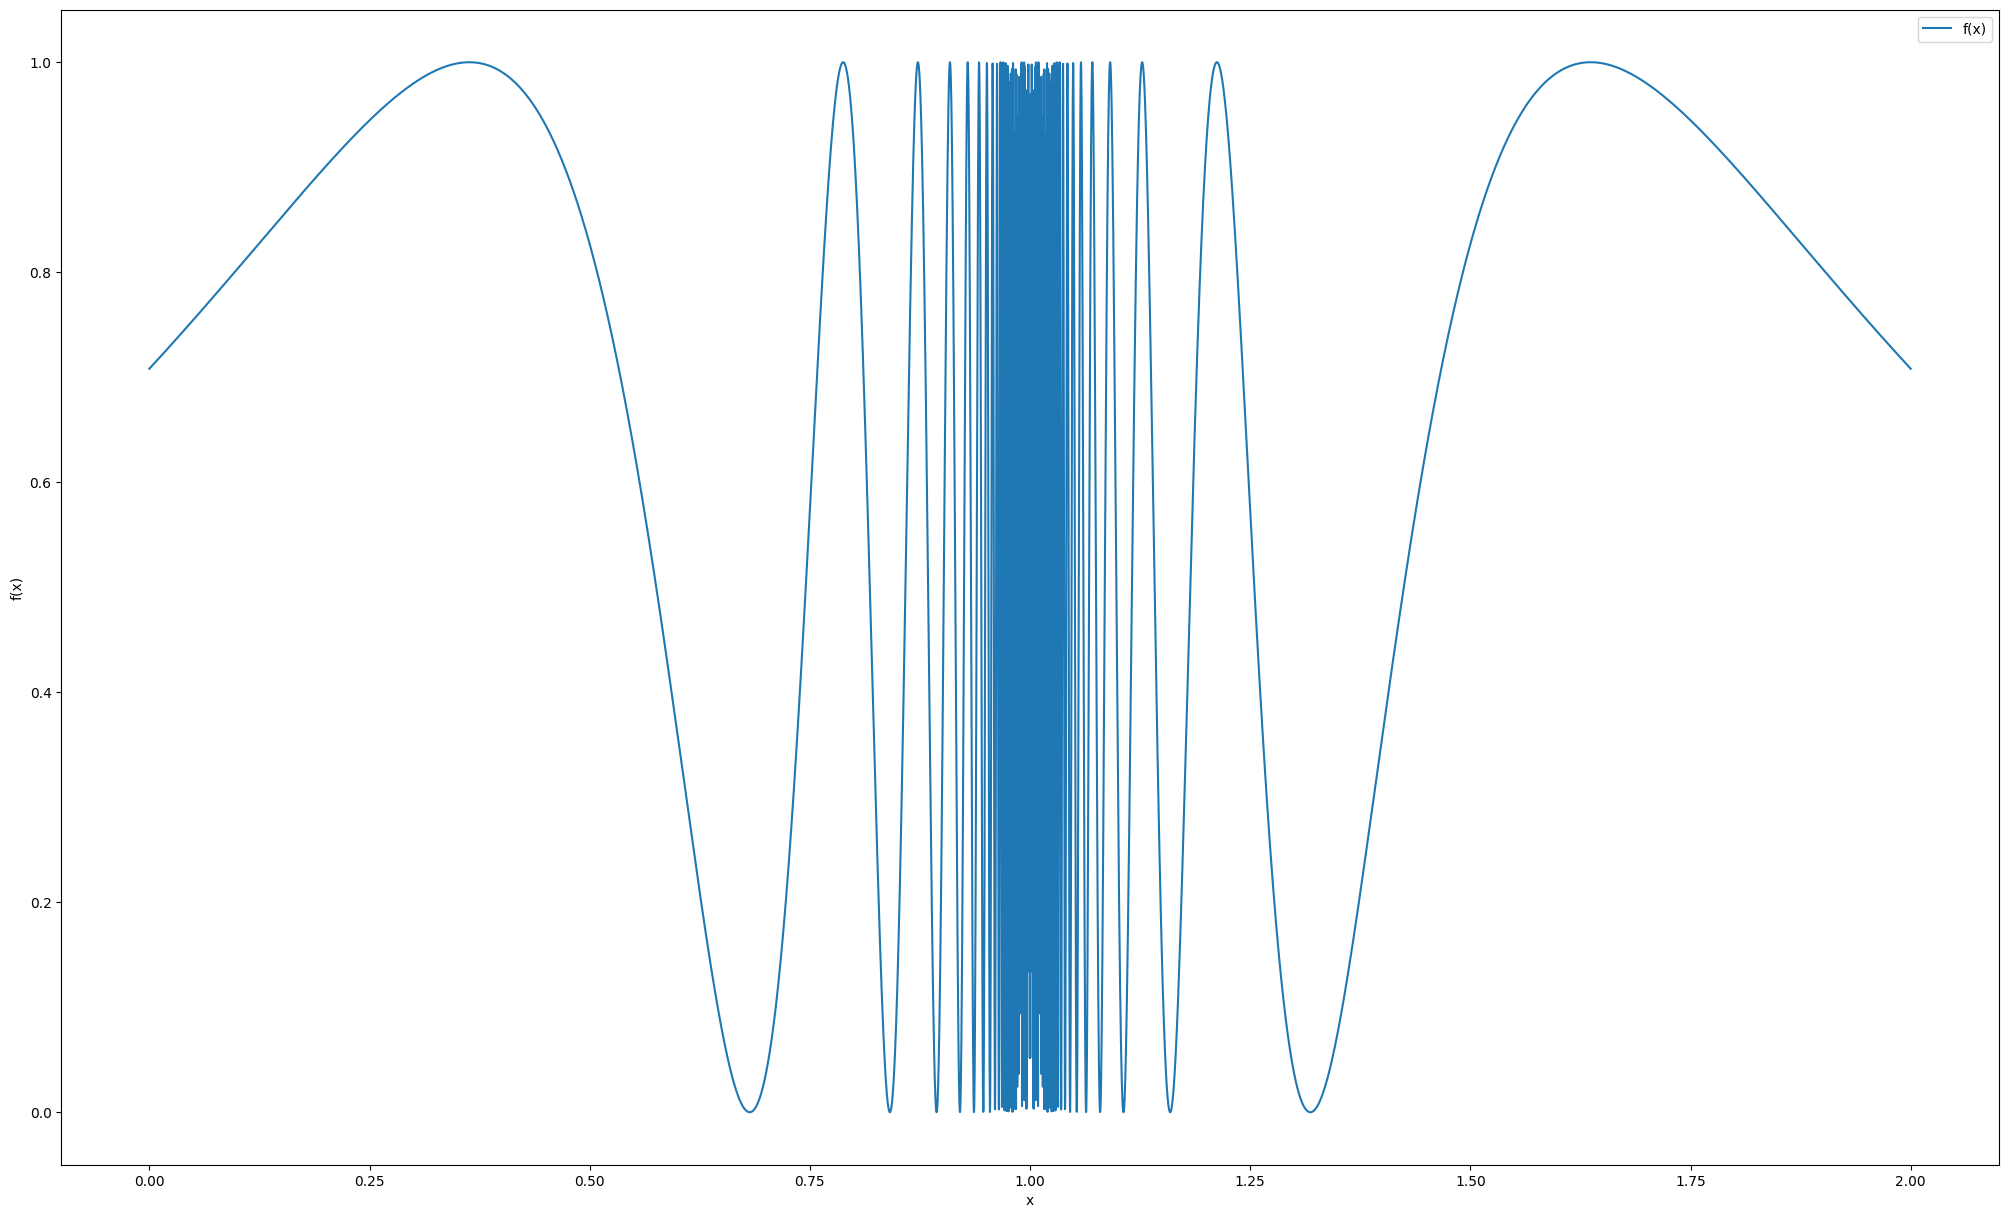

In [4]:
f = lambda x : np.sin(1/(1 - x))**2
#Limits of integration
a, b = 0, 2 
N = 10000
x = np.linspace(a,b, N)
plt.figure(figsize=(25,15))
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(['f(x)'])

In [5]:
def g(x):
    if x == 1:
        return 0
    else:
        return np.sin(1/(1 - x)) ** 2
Integral_true, error = integrate.quad(g,a,b)
print("True integral:", Integral_true)

True integral: 1.3471135014273619


C:\Users\yesmi\AppData\Local\Temp\ipykernel_17812\3965599856.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral_true, error = integrate.quad(g,a,b)


In [6]:
nbr_hits = 0
for i in range(N):
    x = b*np.random.random()
    y = np.random.uniform(0, 1)
    if y <= f(x):
        nbr_hits += 1
integral = (b - a) * (nbr_hits / N)
print("Integral:", integral)
print('Error:', abs(Integral_true-integral))

Integral: 1.347
Error: 0.00011350142736188396


In [7]:
total = 0
for i in range(N):
    x = b * np.random.uniform()
    total += f(x)
integral = (b - a) * (total / N)
print("Integral:", integral)
print('Error:', abs(Integral_true-integral))

Integral: 1.3565256544735826
Error: 0.009412153046220784


* Monte Carlo integration: hit/miss : Integral Value: **1.3468**, Error: **0.00031**
* Monte Carlo integration: mean value method : Integral Value : **1.3428**, Error: **0.00421**

> The Hit/miss Method gave much better results

this could be explained by the fact that our function is very complex and it is defined for all values between 0 and 2, excluding x = 1
For complex functions, the Monte Carlo hit-and-miss method would generally be a better choice than the mean-value method for several reasons:

* Complex functions may have irregular shapes, singularities, or multiple dimensions that make it difficult to implement deterministic methods such as the Riemann sum.

* Complex functions may have areas that are difficult to evaluate using deterministic methods, while the hit-and-miss method can generate random samples that can explore these areas.

* The hit-and-miss method can handle functions that are not easy to integrate analytically.

But, the Monte Carlo hit-and-miss method does require a large number of samples to achieve high precision, which can be computationally expensive. It's also less accurate than other methods, especially for functions with sharp features.

-----


3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [8]:
def f(x):
    s = np.sum(i**2 for i in x)
    if s <= 1 :
        return 1
    else :
        return 0

In [9]:
# limits of integration
a,b = -1,1
N=100000
dim = 2

x = np.random.uniform(-1, 1, size=(N, dim))
Integral_true = np.pi * a**2
print("True integral:", Integral_true)

True integral: 3.141592653589793


In [10]:
I = np.sum([f(i) for i in x ])
integral = (2**dim)*I/N
print("Integral:", integral)
print('Error:', abs(Integral_true-integral))

C:\Users\yesmi\AppData\Local\Temp\ipykernel_17812\1984196269.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s = np.sum(i**2 for i in x)


Integral: 3.14336
Error: 0.001767346410206816


In [11]:
dim=10
x = np.random.uniform(-1, 1, size=(N, dim))

I = np.sum([f(i) for i in x ])
integral = (2**dim)*I/N
print("Integral:", integral)

C:\Users\yesmi\AppData\Local\Temp\ipykernel_17812\1984196269.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s = np.sum(i**2 for i in x)


Integral: 2.44736


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [12]:
f = lambda x : x**(-1/2)/(np.exp(x) + 1 )
w = lambda x : 1/np.sqrt(x)
inv_cdf = lambda x : (x**2)/4

In [13]:
# limits of integration
a,b, N = 0, 1, 100000

x = np.random.uniform(0, 2, size=N)
Integral_true, error = integrate.quad(f,a,b)
print("True integral:", Integral_true)

True integral: 0.8389329600133838


In [14]:
# the value of integral of w in [0,1]
w_integral = 2

x = inv_cdf(x)
integral = np.sum(f(x)/w(x))*(w_integral/N)

print("Integral:", integral)
print('Error:', abs(Integral_true-integral))

Integral: 0.8385362279173891
Error: 0.0003967320959946674
